In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.manifold import TSNE
from pathlib import Path
import sys
sys.path.append("../")
from lib.datasets import HomogeneousPipelineDataset
import json
import os
import pickle
from pathlib import Path
from tqdm import tqdm
from itertools import chain
from fedot.core.repository.default_params_repository import DefaultOperationParamsRepository
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Any, Dict, Tuple, Iterable
from fedot.core.operations.evaluation.evaluation_interfaces import SkLearnEvaluationStrategy
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.express as px

from sklearn.manifold import TSNE, MDS

In [2]:
class PipelineJSON2Pickle:
    def __init__(self, pipelines_directory):
        self.file_names = list(Path(pipelines_directory).glob("**/*.json"))
        self.default_operation_params = DefaultOperationParamsRepository()._repo

    def get_operations_ids(self, nodes: List[Dict[str, Any]]) -> List[int]:
        return [node["operation_id"] for node in nodes]

    def get_operations_names(self, nodes: List[Dict[str, Any]]) -> List[str]:
        return [node["operation_name"] for node in nodes]

    def get_operations_params(self, nodes: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        params_list = []
        for node in nodes:
            operation_type = node["operation_type"]
            try:
                params = self.default_operation_params[operation_type]
            except KeyError:
                params = {}
            operation_params = node["params"]
            params.update(operation_params)
            params_list.append(params)
        return params_list

    def get_graph_edges(self, nodes: List[Dict[str, Any]]) -> List[List[int]]:
        edges = []
        for node in nodes:
            nodes_from = node["nodes_from"]
            if len(nodes_from) > 0:
                target = node["operation_id"]
                for source in nodes_from:
                    edges.append([source, target])
        return edges

    # TODO: not optimal solution. Rewrite code with use of correct index in `get_...` methods
    def fix_operations_order(self, nodes: List[Dict[str, Any]], *args: Iterable[List[Any]]) -> List[List[Any]]:
        node_ids = self.get_operations_ids(nodes)
        correct_node_ids = np.array(node_ids).argsort()
        res = []
        for arg in args:
            tmp = [arg[i] for i in correct_node_ids]
            res.append(tmp)
        return res

    def convert(self):
        nns = []
        nps = []
        eis = []
        for filename in tqdm(self.file_names):
            with open(filename) as f:
                data = json.load(f)
            nodes = data["nodes"]

            node_names = self.get_operations_names(nodes)
            node_parameters = self.get_operations_params(nodes)
            node_names, node_parameters = self.fix_operations_order(nodes, node_names, node_parameters)

            edge_index = self.get_graph_edges(nodes)

            nns.append(node_names)
            nps.append(node_parameters)
            eis.append(edge_index)
        return nns, nps, eis
            # base_name = os.path.basename(filename).split(".")[0]
            # dirname = os.path.dirname(filename)
            # with open(os.path.join(dirname, f"{base_name}.pickle"), "wb") as f:
            #     pickle.dump({"node_names": node_names, "node_parameters": node_parameters, "edge_index": edge_index}, f)

In [3]:
PATH = r"C:\Users\Konstantin\PycharmProjects\NIR\dataset\pipeline_dataset\pipelines"
converter = PipelineJSON2Pickle(PATH)
node_names, node_parameters, edge_index = converter.convert()

100%|██████████| 5695/5695 [00:01<00:00, 5549.80it/s]


In [4]:
metrics_directory = r"C:\Users\Konstantin\PycharmProjects\NIR\dataset\pipeline_dataset\metrics"
file_names = list(Path(metrics_directory).glob("**/*.pickle"))

roc_auc = []
f1 = []
for fname in file_names:
    with open(fname, "rb") as f:
        data = pickle.load(f)
        roc_auc.append(data["roc_auc"])
        f1.append(data["f1"])

In [17]:
u = np.unique(list(chain.from_iterable(node_names)))
df = pd.DataFrame(columns = u)
res = []
for i, nodes in enumerate(node_names):
    series = pd.Series(np.zeros(len(u), dtype=int), index=u)
    series[nodes] = 1
    res.append(series)
df = pd.DataFrame(res)
df["roc_auc"] = np.array(roc_auc)
df["f1"] = np.array(f1)
df["g_len"] = list(map(len, node_names))
df["last_node"] = list(map(lambda x: x[-1], node_names))

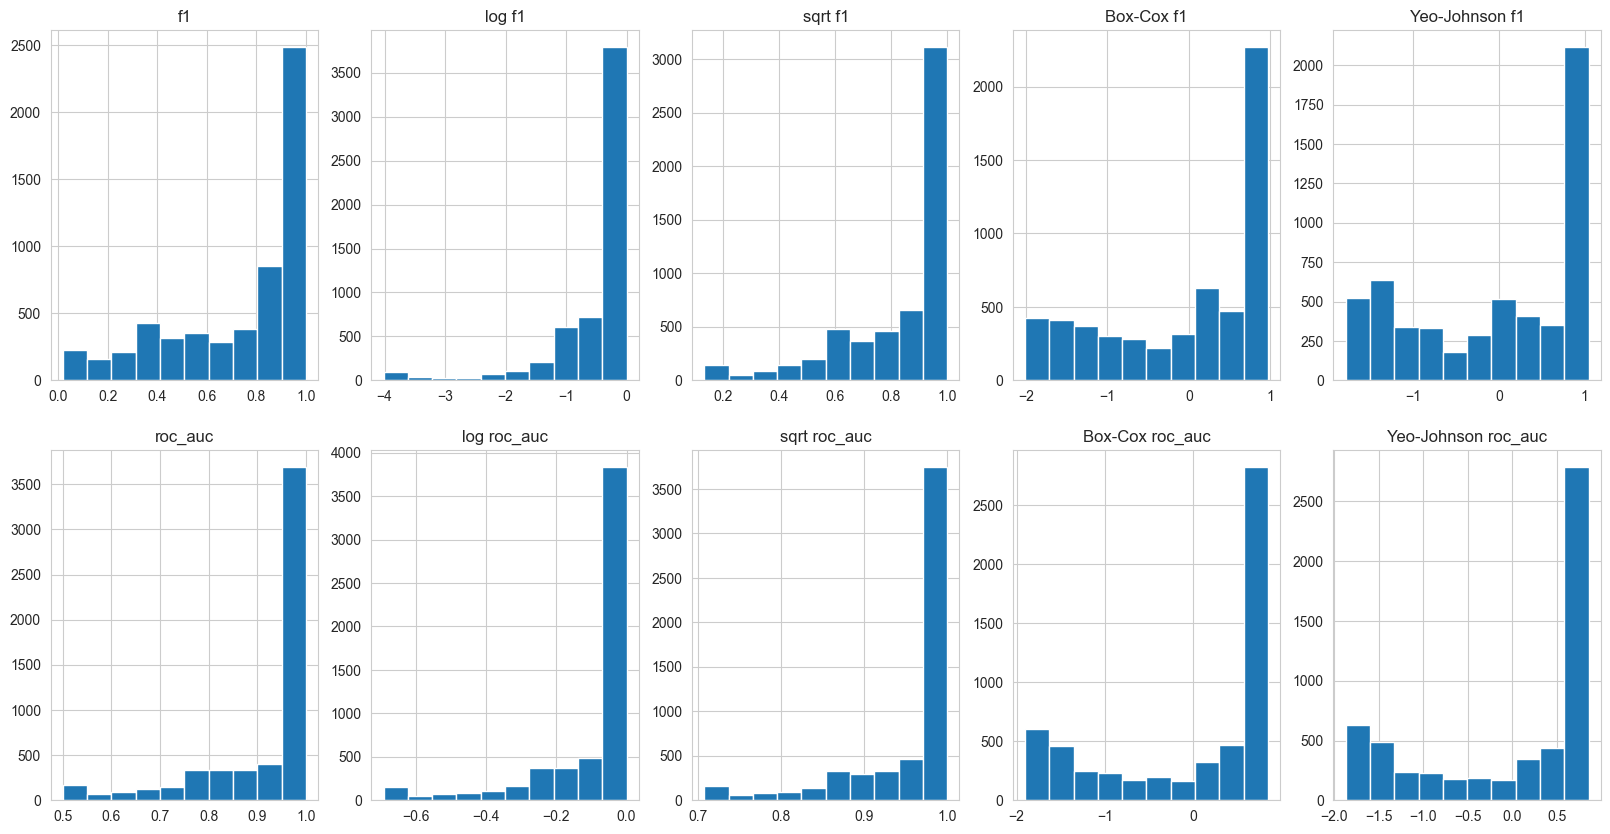

In [26]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
ax[0][0].hist(df["f1"])
ax[0][0].set_title("f1")
ax[0][1].hist(np.log(df["f1"]))
ax[0][1].set_title("log f1")
ax[0][2].hist(np.sqrt(df["f1"]))
ax[0][2].set_title("sqrt f1")
ax[0][3].hist(PowerTransformer(method="box-cox").fit_transform(df["f1"].to_numpy().reshape(-1,1)).reshape(-1))
ax[0][3].set_title("Box-Cox f1")
ax[0][4].hist(PowerTransformer(method="yeo-johnson").fit_transform(df["f1"].to_numpy().reshape(-1,1)).reshape(-1))
ax[0][4].set_title("Yeo-Johnson f1")

ax[1][0].hist(df["roc_auc"])
ax[1][0].set_title("roc_auc")
ax[1][1].hist(np.log(df["roc_auc"]))
ax[1][1].set_title("log roc_auc")
ax[1][2].hist(np.sqrt(df["roc_auc"]))
ax[1][2].set_title("sqrt roc_auc")
ax[1][3].hist(PowerTransformer(method="box-cox").fit_transform(df["roc_auc"].to_numpy().reshape(-1,1)).reshape(-1))
ax[1][3].set_title("Box-Cox roc_auc")
ax[1][4].hist(PowerTransformer(method="yeo-johnson").fit_transform(df["roc_auc"].to_numpy().reshape(-1,1)).reshape(-1))
ax[1][4].set_title("Yeo-Johnson roc_auc")

plt.show()

In [44]:
tsne = TSNE(2, perplexity=100, metric="cosine")
transformed = tsne.fit_transform(df[[c for c in filter(lambda x: x not in ["g_len", "f1", "roc_auc", "last_node"], df.columns)]])

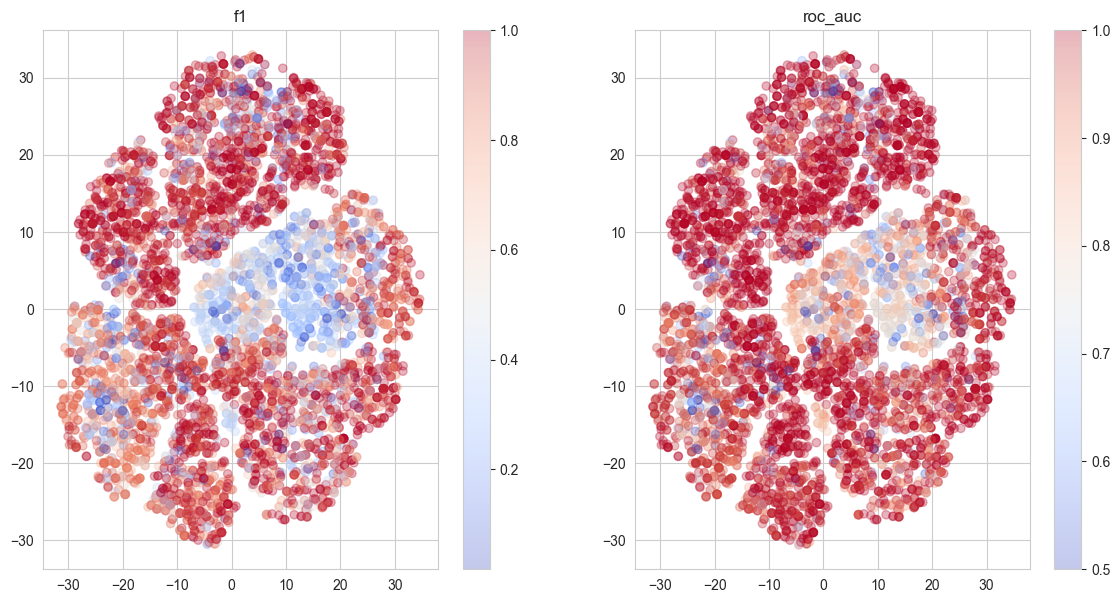

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
im=ax[0].scatter(*transformed.T, c=df["f1"], cmap="coolwarm", alpha=0.3)
ax[0].set_title("f1")
plt.colorbar(im, ax=ax[0])
im=ax[1].scatter(*transformed.T, c=df["roc_auc"], cmap="coolwarm", alpha=0.3)
ax[1].set_title("roc_auc")
plt.colorbar(im, ax=ax[1])
plt.show()

In [49]:
tsne = TSNE(2, perplexity=100)
transformed = tsne.fit_transform(df[[c for c in filter(lambda x: x not in ["f1", "roc_auc", "last_node"], df.columns)]])

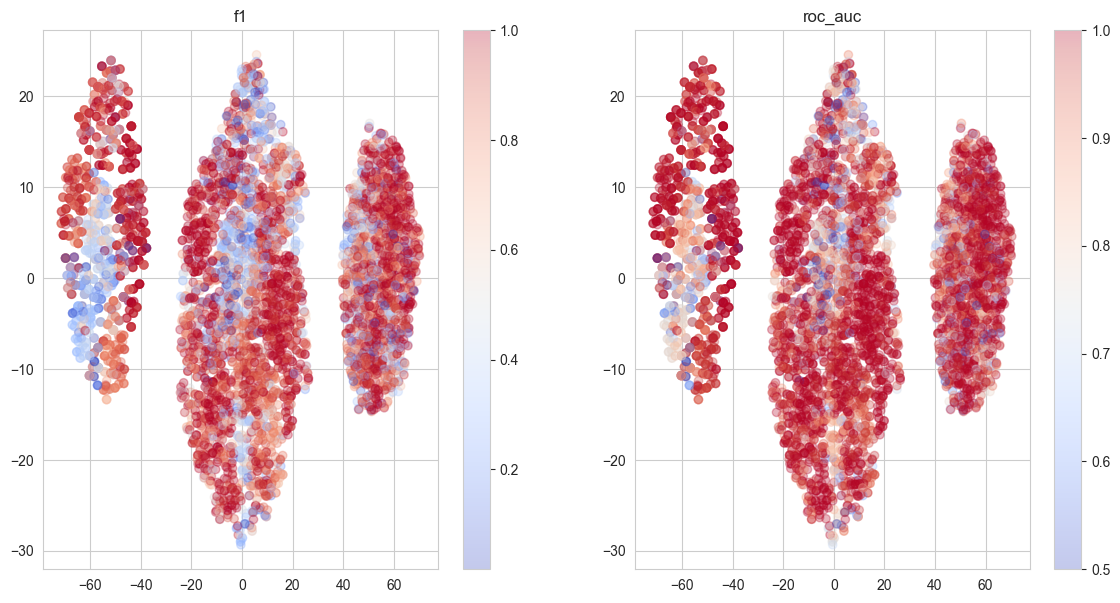

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
im=ax[0].scatter(*transformed.T, c=df["f1"], cmap="coolwarm", alpha=0.3)
ax[0].set_title("f1")
plt.colorbar(im, ax=ax[0])
im=ax[1].scatter(*transformed.T, c=df["roc_auc"], cmap="coolwarm", alpha=0.3)
ax[1].set_title("roc_auc")
plt.colorbar(im, ax=ax[1])
plt.show()

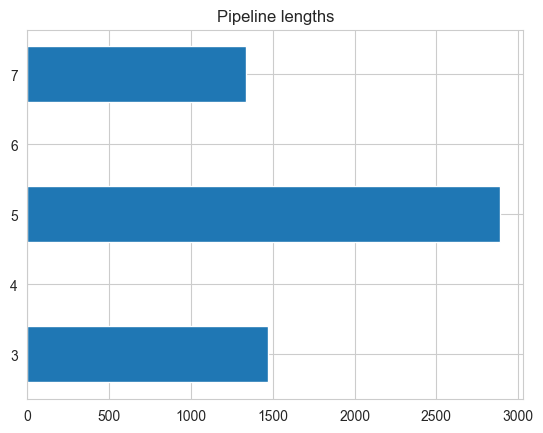

In [19]:
u, c = np.unique(df["g_len"], return_counts=True)
plt.barh(u, c)
plt.title("Pipeline lengths")
plt.show()

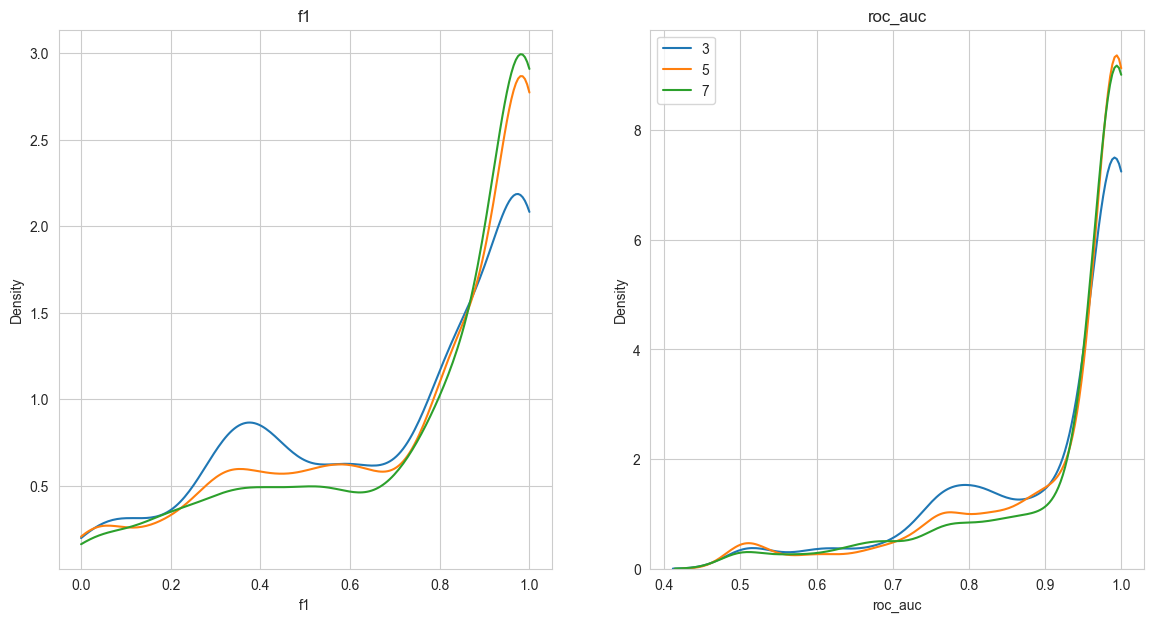

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
for gname, group in df.groupby("g_len"):
    sns.kdeplot(group["f1"], ax=ax[0], label=gname, clip=[0, 1])
    sns.kdeplot(group["roc_auc"], ax=ax[1], label=gname, clip=[0, 1])
ax[0].set_title("f1")
ax[1].set_title("roc_auc")
plt.legend()
plt.show()

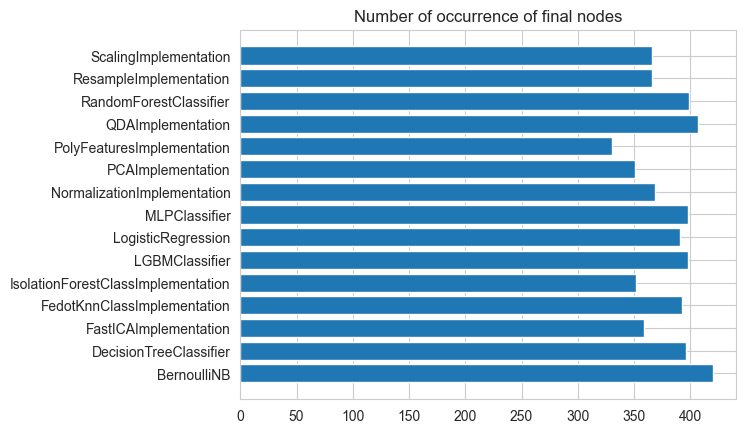

In [20]:
u, c = np.unique(df["last_node"], return_counts=True)
plt.barh(u, c)
plt.title("Number of occurrence of final nodes")
plt.show()

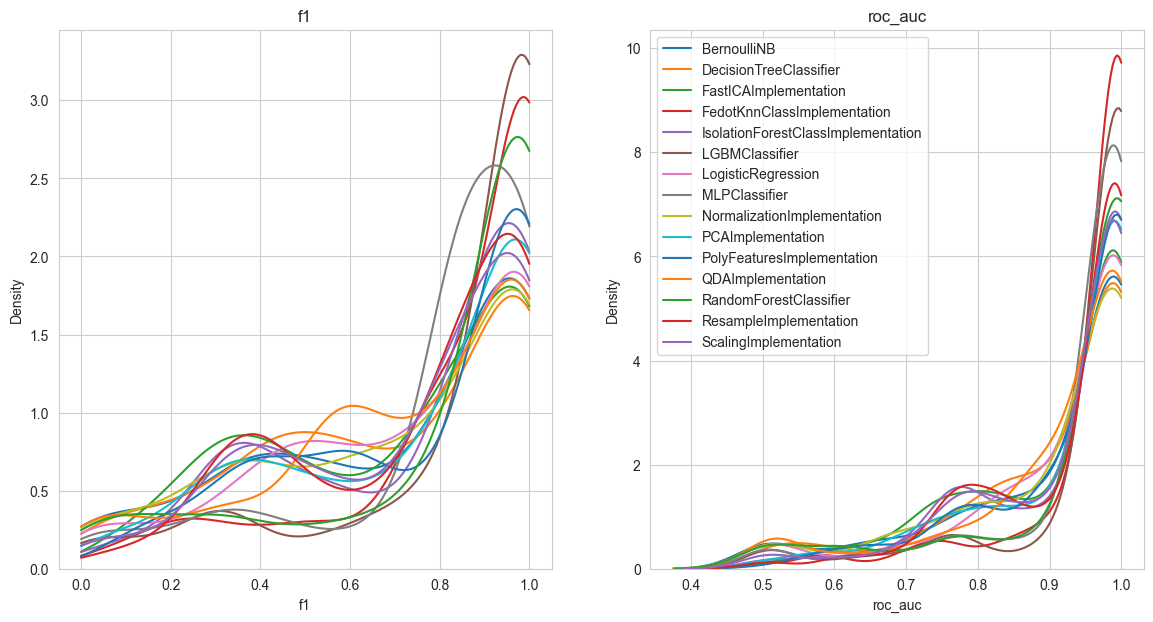

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
for gname, group in df.groupby("last_node"):
    sns.kdeplot(group["f1"], ax=ax[0], label=gname, clip=[0, 1])
    sns.kdeplot(group["roc_auc"], ax=ax[1], label=gname, clip=[0, 1])
ax[0].set_title("f1")
ax[1].set_title("roc_auc")
plt.legend()
plt.show()